## How do public sentiments towards immigrants change after external shocks?

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [65]:
# Display all columns
pd.set_option('display.max_columns', None)

# Style
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 5)

# Load data
data_path = "../data/reddit_comments_with_sentiment.csv"
df = pd.read_csv(data_path)
df.head()

,keyword,post_title,comment,score,created_utc,sentiment_score,sentiment_label
0,immigrant,British expats 'in tears' as Spain to deport 5...,Users often report submissions from this site ...,1,1.616873e+09,0.5994,positive
1,immigrant,British expats 'in tears' as Spain to deport 5...,I really don’t know what all the whining is ab...,13748,1.616880e+09,0.8893,positive
2,immigrant,British expats 'in tears' as Spain to deport 5...,Seriously why didn't they just register when a...,7845,1.616874e+09,-0.7003,negative
3,immigrant,British expats 'in tears' as Spain to deport 5...,"""I think the Spanish will regret chucking us o...",9591,1.616875e+09,-0.2023,negative
4,immigrant,British expats 'in tears' as Spain to deport 5...,An absolute gem in this article is Shaun Cromb...,12225,1.616876e+09,0.6542,positive


In [66]:
# Clean column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Remove duplicates & NaN
df = df.drop_duplicates(subset=["comment"]).dropna(subset=["sentiment_score", "sentiment_label"])

# Convert timestamp
df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s")

# Sort from oldest to newest
df = df.sort_values(by="created_utc", ascending=True)

df.head()


,keyword,post_title,comment,score,created_utc,sentiment_score,sentiment_label
8702,refugee,"France Rejects Fear, Renews Commitment To Take...",As the [Economist](http://www.economist.com/ne...,3113,2015-11-18 15:31:53,-0.9650,negative
8808,refugee,"France Rejects Fear, Renews Commitment To Take...","> Additionally, taking in 30,000 over two year...",99,2015-11-18 15:49:21,-0.7650,negative
8731,refugee,"France Rejects Fear, Renews Commitment To Take...",so TIL the current regime of France will be vo...,385,2015-11-18 16:01:31,-0.4019,negative
8785,refugee,"France Rejects Fear, Renews Commitment To Take...","I am all for helping refugees, but it's import...",15,2015-11-18 16:12:17,0.9403,positive
8721,refugee,"France Rejects Fear, Renews Commitment To Take...",Are they going to have any way of determining ...,58,2015-11-18 16:23:33,0.0243,neutral


In [67]:
# defining events (all within range)
# Defining events (expanded with migration & border-related events)
external_events = {
    # European migrant crisis
    "European Migrant Crisis Peak": "2015-09-01",
    "EU-Turkey Deal": "2016-03-18",
    
    # U.S. Trump administration policies
    "2016 US Election": "2016-11-08",
    "Travel Ban": "2017-01-27",
    "Family Separations": "2018-06-01",
    "H1B Policy": "2017-04-18",
    "Remain in Mexico Policy": "2019-01-24",
    "Public Charge Rule": "2019-08-14",
    "COVID-19 Border Closures": "2020-03-20",
    
    # U.S. elections and related events
    "2020 US Election": "2020-11-03",
    "Afghanistan Withdrawal": "2021-08-15",
    "2022 Midterms": "2022-11-08",
    
    # Biden administration policies
    "Reversing Trump-era Policies": "2021-01-20",
    "Expansion of Legal Pathways": "2021-09-01",
    "Temporary Border Closures": "2024-01-15",
    
    # Upcoming election
    "2024 US Election": "2024-11-05"
}



### We are analyzing sentiment around major external events to understand how they influence public opinion and behavior. This approach allows us to quantify changes and gain insights from the data. Specifically:

-- Measure shifts in public opinion: By comparing sentiment before and after an event, we can see whether people felt more positive, negative, or neutral.

-- Quantify event impact: The difference between post-event and pre-event sentiment provides a numerical measure of the strength of reactions.

-- Capture temporal context: Using a window of days around each event smooths short-term fluctuations while focusing on trends directly related to the event.

-- Handle sparse or edge data: Dynamically expanding the window ensures that events near the dataset boundaries or with few posts are still included.

-- Provide data-driven insights: This method allows us to answer questions such as which events caused the strongest reactions, or how public sentiment changed in response to policy, elections, or global crises.

In [68]:
# Ensure datetime and sort
df['created_utc'] = pd.to_datetime(df['created_utc'])
df = df.sort_values('created_utc')

initial_window = 365      # starting window (days)
max_window = 730          # maximum window (days)
window_step = 30          # how much to expand each iteration
results = []

min_date = df['created_utc'].min()
max_date = df['created_utc'].max()

for event, date in external_events.items():
    event_date = pd.to_datetime(date)
    window = initial_window

    while window <= max_window:
        pre_start = max(event_date - pd.Timedelta(days=window), min_date)
        pre_end = event_date
        post_start = event_date + pd.Timedelta(seconds=1)
        post_end = min(event_date + pd.Timedelta(days=window), max_date)

        pre_period = df[(df['created_utc'] >= pre_start) & (df['created_utc'] < pre_end)]['sentiment_score']
        post_period = df[(df['created_utc'] >= post_start) & (df['created_utc'] <= post_end)]['sentiment_score']

        if not pre_period.empty and not post_period.empty:
            results.append({
                'Event': event,
                'Date': event_date.date(),
                'Pre Avg': round(pre_period.mean(), 3),
                'Post Avg': round(post_period.mean(), 3),
                'Change (Post-Pre)': round(post_period.mean() - pre_period.mean(), 3)
            })
            break  # found data, move to next event
        else:
            window += window_step  # expand window

    else:  # loop exhausted without finding data
        print(f"⚠️ No data found for {event} ({date}) even after expanding window.")

event_sentiment_change = pd.DataFrame(results).sort_values('Date').reset_index(drop=True)
print(event_sentiment_change)


⚠️ No data found for European Migrant Crisis Peak (2015-09-01) even after expanding window.
                           Event        Date  Pre Avg  Post Avg  \
0                 EU-Turkey Deal  2016-03-18   -0.083     0.097   
1               2016 US Election  2016-11-08   -0.083     0.097   
2                     Travel Ban  2017-01-27   -0.083     0.073   
3                     H1B Policy  2017-04-18    0.097     0.050   
4             Family Separations  2018-06-01    0.050    -0.019   
5        Remain in Mexico Policy  2019-01-24   -0.039    -0.105   
6             Public Charge Rule  2019-08-14   -0.083     0.000   
7       COVID-19 Border Closures  2020-03-20   -0.070    -0.108   
8               2020 US Election  2020-11-03    0.000    -0.063   
9   Reversing Trump-era Policies  2021-01-20   -0.042    -0.053   
10        Afghanistan Withdrawal  2021-08-15   -0.048     0.079   
11   Expansion of Legal Pathways  2021-09-01   -0.048     0.080   
12                 2022 Midterms  202

This output tells us how public sentiment changed around each major event based on your dataset of posts/comments. Here’s a clear interpretation:

-- Pre Avg: The average sentiment in the period before the event. Negative values indicate generally negative sentiment, positive values indicate positive sentiment.

-- Post Avg: The average sentiment in the period after the event.

-- Change (Post-Pre): How sentiment shifted after the event. Positive values mean sentiment became more positive; negative values mean it became more negative.

2016 US Election: Sentiment shifted from slightly negative (-0.083) to positive (0.097), showing a moderate increase in positive sentiment (+0.180).

Travel Ban (2017-01-27): Sentiment improved from -0.083 to 0.073, a positive shift (+0.156).

H1B Policy (2017-04-18): Sentiment decreased from 0.097 to 0.050, a slight negative shift (-0.047).

COVID-19 Pandemic: Sentiment dropped from -0.070 to -0.108, showing a further decline in sentiment (-0.038).

2022 Midterms: Sentiment dropped from 0.249 to 0.080, a significant negative shift (-0.169).

Events like the US Elections and Travel Ban triggered positive sentiment changes, suggesting public optimism or support in reaction.

Events like COVID-19, H1B Policy, and the 2022 Midterms triggered negative sentiment changes, indicating concern, fear, or dissatisfaction.

The magnitude of Change (Post-Pre) tells us which events had the strongest emotional impact on the public.

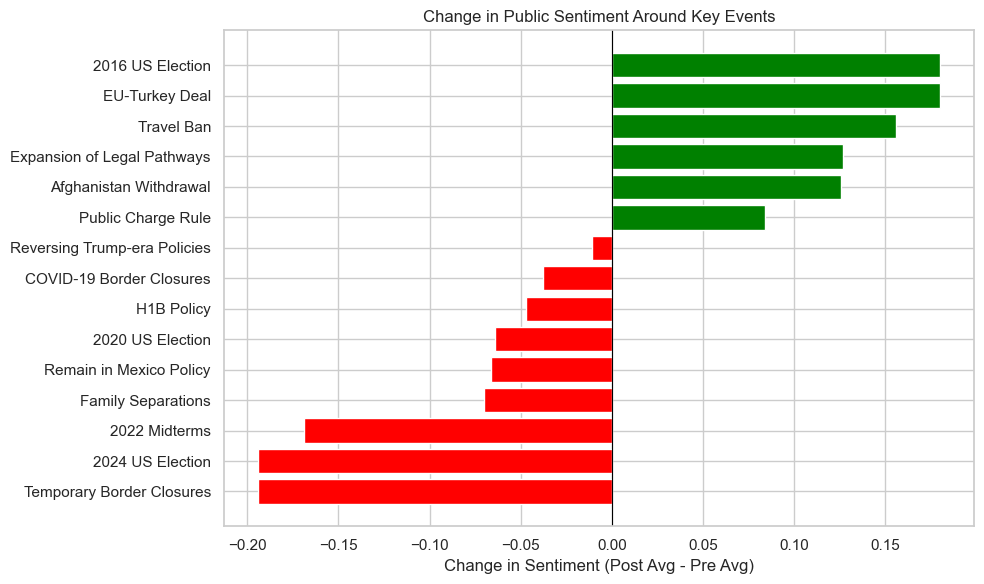

In [69]:
# Sort events by Change for better visualization
event_sentiment_change_sorted = event_sentiment_change.sort_values('Change (Post-Pre)')

# Colors: positive change = green, negative change = red
colors = ['green' if x > 0 else 'red' for x in event_sentiment_change_sorted['Change (Post-Pre)']]

plt.figure(figsize=(10,6))
plt.barh(event_sentiment_change_sorted['Event'], 
         event_sentiment_change_sorted['Change (Post-Pre)'], 
         color=colors)

plt.xlabel('Change in Sentiment (Post Avg - Pre Avg)')
plt.title('Change in Public Sentiment Around Key Events')
plt.axvline(0, color='black', linewidth=0.8)  # reference line at 0
plt.tight_layout()
plt.show()


In [70]:
from collections import Counter
import re

# Function to clean and tokenize text
def tokenize(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|[^a-z\s]', '', text)  # remove URLs, punctuation, numbers
    return text.split()

# Store results
word_freq_results = []

for event, date in external_events.items():
    event_date = pd.to_datetime(date)
    
    # Pre and post periods
    pre_mask = (df['created_utc'] >= event_date - pd.Timedelta(days=window_days)) & \
               (df['created_utc'] < event_date)
    post_mask = (df['created_utc'] > event_date) & \
                (df['created_utc'] <= event_date + pd.Timedelta(days=window_days))
    
    pre_comments = df.loc[pre_mask, 'comment'].dropna().tolist()
    post_comments = df.loc[post_mask, 'comment'].dropna().tolist()
    
    if not pre_comments or not post_comments:
        continue
    
    # Flatten list of words
    pre_words = [w for comment in pre_comments for w in tokenize(comment)]
    post_words = [w for comment in post_comments for w in tokenize(comment)]
    
    # Count top 10 words
    pre_top = Counter(pre_words).most_common(10)
    post_top = Counter(post_words).most_common(10)
    
    word_freq_results.append({
        'Event': event,
        'Pre Top Words': pre_top,
        'Post Top Words': post_top
    })

word_freq_df = pd.DataFrame(word_freq_results)
word_freq_df


,Event,Pre Top Words,Post Top Words
0,EU-Turkey Deal,"[(the, 802), (to, 536), (and, 435), (of, 425),...","[(the, 1473), (to, 919), (and, 774), (a, 719),..."
1,2016 US Election,"[(the, 802), (to, 536), (and, 435), (of, 425),...","[(the, 1473), (to, 919), (and, 774), (a, 719),..."
2,Family Separations,"[(the, 1410), (to, 849), (a, 726), (of, 666), ...","[(the, 1409), (to, 702), (of, 651), (a, 644), ..."
3,H1B Policy,"[(the, 1473), (to, 919), (and, 774), (a, 719),...","[(the, 1410), (to, 849), (a, 726), (of, 666), ..."
4,Remain in Mexico Policy,"[(the, 967), (to, 470), (of, 426), (a, 335), (...","[(the, 1267), (to, 674), (a, 640), (and, 589),..."
5,Public Charge Rule,"[(the, 2227), (to, 1136), (of, 1001), (a, 969)...","[(the, 750), (to, 519), (and, 436), (a, 419), ..."
6,COVID-19 Border Closures,"[(the, 2016), (to, 1193), (a, 1059), (and, 102...","[(the, 1252), (to, 755), (and, 671), (a, 605),..."
7,2020 US Election,"[(the, 750), (to, 519), (and, 436), (a, 419), ...","[(the, 2035), (to, 1306), (and, 1082), (a, 990..."
8,Reversing Trump-era Policies,"[(the, 1288), (to, 866), (and, 751), (a, 703),...","[(the, 1497), (to, 959), (and, 767), (a, 706),..."


It looks like theres a lot of articles so im removing stopwords

In [71]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = text.lower()
    text = re.sub(r'http\S+|[^a-z\s]', '', text)
    return [w for w in text.split() if w not in stop_words]

word_freq_results = []

max_window = 730  # max expansion if needed

for event, date in external_events.items():
    event_date = pd.to_datetime(date)
    window = 365  # initial window
    
    while window <= max_window:
        pre_mask = (df['created_utc'] >= event_date - pd.Timedelta(days=window)) & \
                   (df['created_utc'] < event_date)
        post_mask = (df['created_utc'] > event_date) & \
                    (df['created_utc'] <= event_date + pd.Timedelta(days=window))
        
        pre_comments = df.loc[pre_mask, 'comment'].dropna().tolist()
        post_comments = df.loc[post_mask, 'comment'].dropna().tolist()
        
        # Break if at least one side has data
        if pre_comments or post_comments:
            break
        else:
            window += 30  # expand window
    
    pre_words = [w for comment in pre_comments for w in tokenize(comment)]
    post_words = [w for comment in post_comments for w in tokenize(comment)]
    
    pre_top = Counter(pre_words).most_common(10)
    post_top = Counter(post_words).most_common(10)
    
    word_freq_results.append({
        'Event': event,
        'Pre Top Words': pre_top,
        'Post Top Words': post_top
    })

word_freq_df = pd.DataFrame(word_freq_results)
word_freq_df


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samiya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Event,Pre Top Words,Post Top Words
0,European Migrant Crisis Peak,[],"[(people, 170), (refugees, 135), (country, 71)..."
1,EU-Turkey Deal,"[(people, 170), (refugees, 135), (country, 71)...","[(people, 218), (canada, 136), (us, 134), (lik..."
2,2016 US Election,"[(people, 170), (refugees, 135), (country, 71)...","[(people, 218), (canada, 136), (us, 134), (lik..."
3,Travel Ban,[],"[(people, 445), (like, 235), (us, 208), (would..."
4,Family Separations,"[(people, 227), (like, 120), (would, 112), (do...","[(people, 178), (like, 109), (one, 97), (dont,..."
5,H1B Policy,"[(people, 218), (canada, 136), (us, 134), (lik...","[(people, 227), (like, 120), (would, 112), (do..."
6,Remain in Mexico Policy,"[(people, 112), (government, 79), (would, 64),...","[(people, 196), (right, 125), (like, 110), (do..."
7,Public Charge Rule,"[(people, 307), (like, 174), (right, 142), (do...","[(people, 113), (years, 68), (like, 67), (get,..."
8,COVID-19 Border Closures,"[(people, 309), (like, 177), (dont, 146), (rig...","[(people, 184), (like, 116), (dont, 111), (us,..."
9,2020 US Election,"[(people, 113), (years, 68), (like, 67), (get,...","[(people, 266), (like, 221), (dont, 178), (wou..."


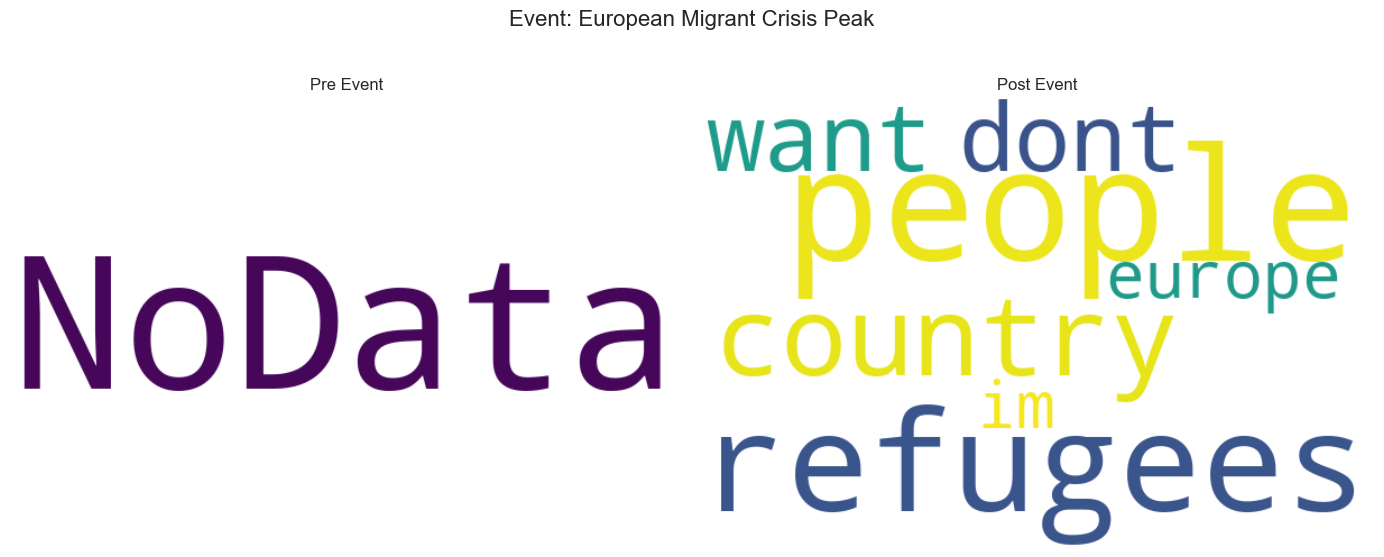

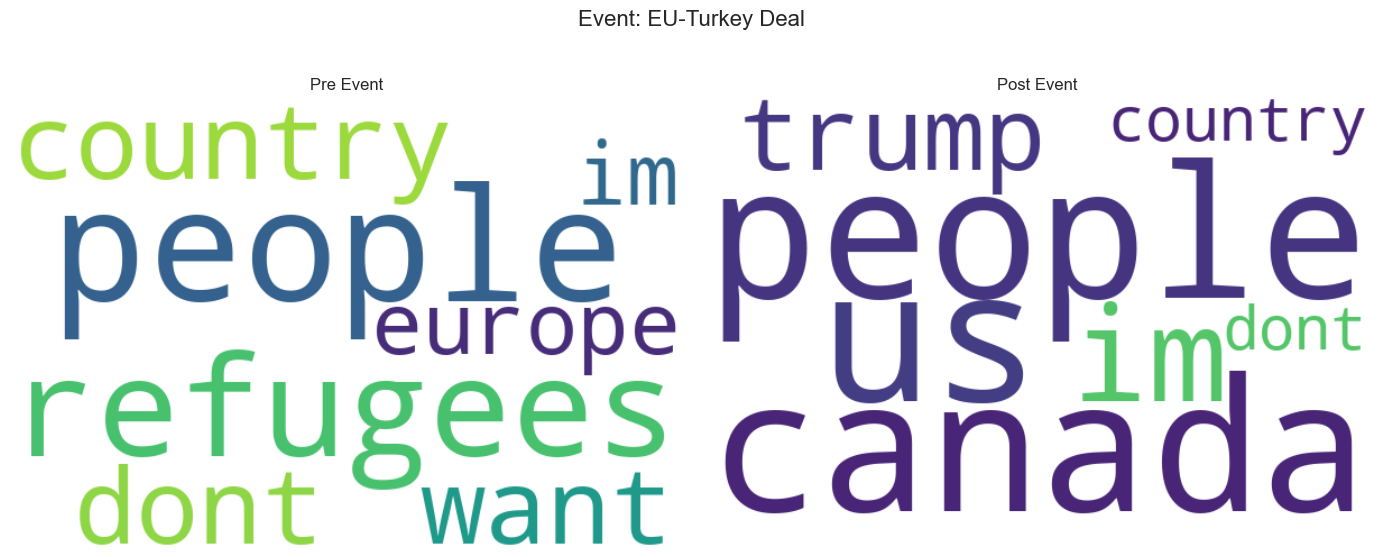

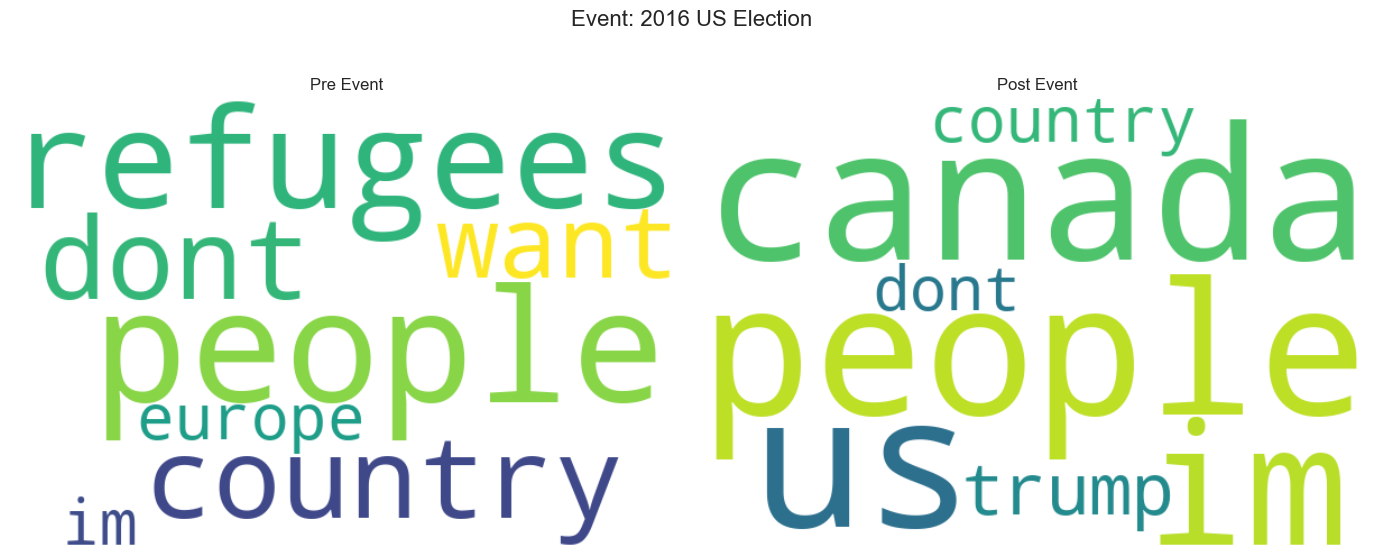

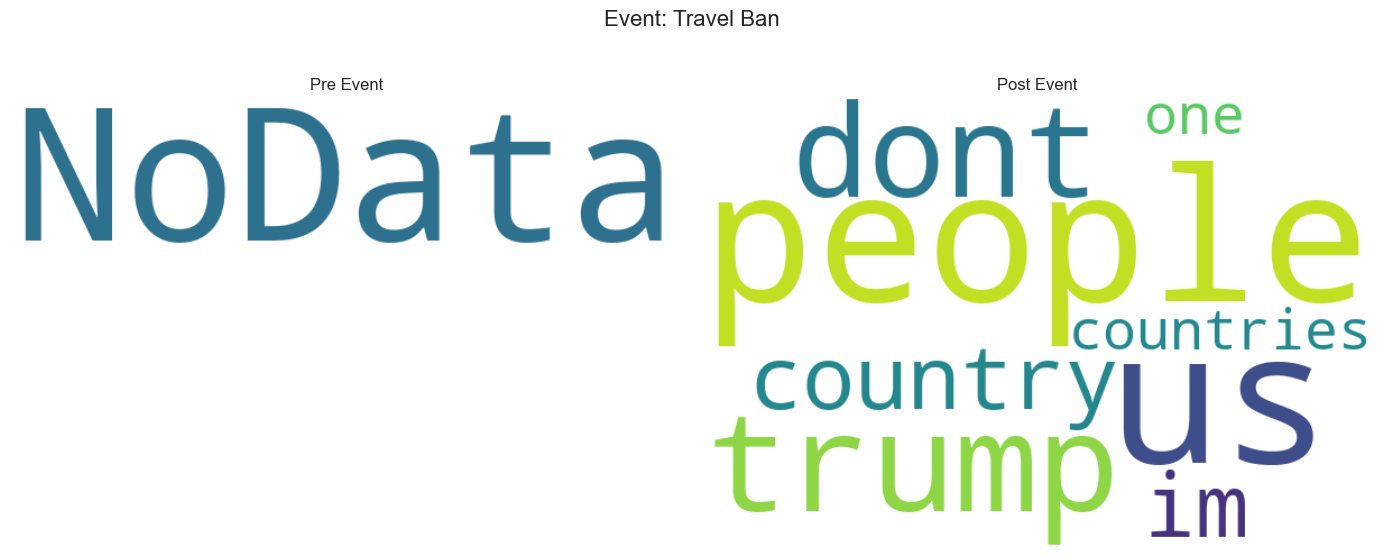

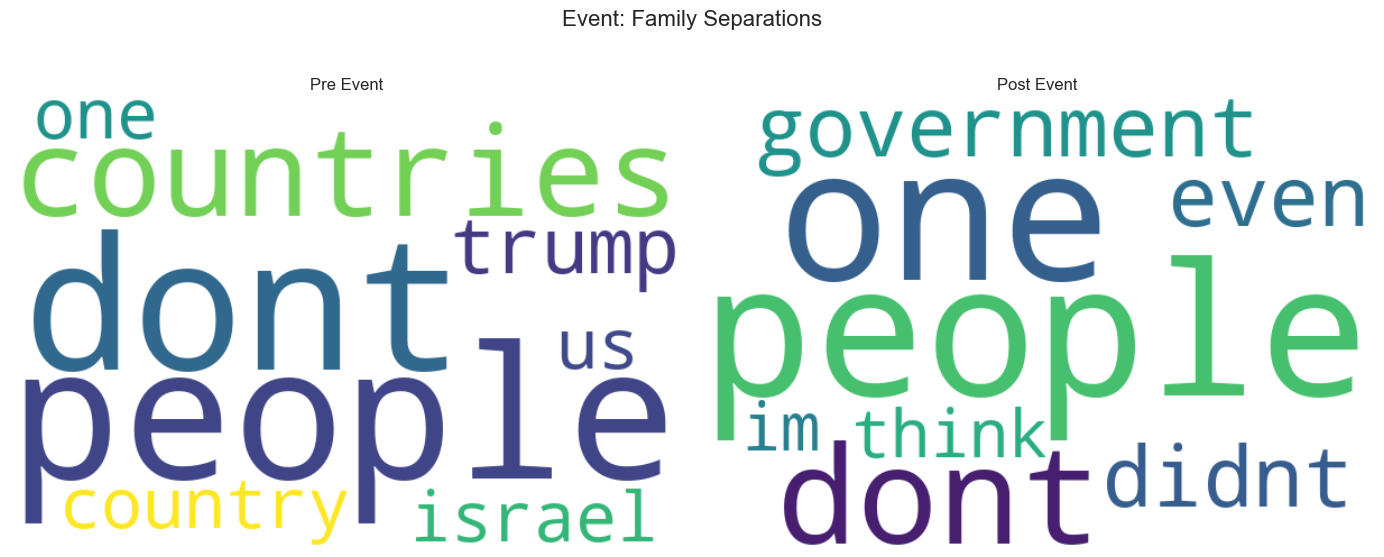

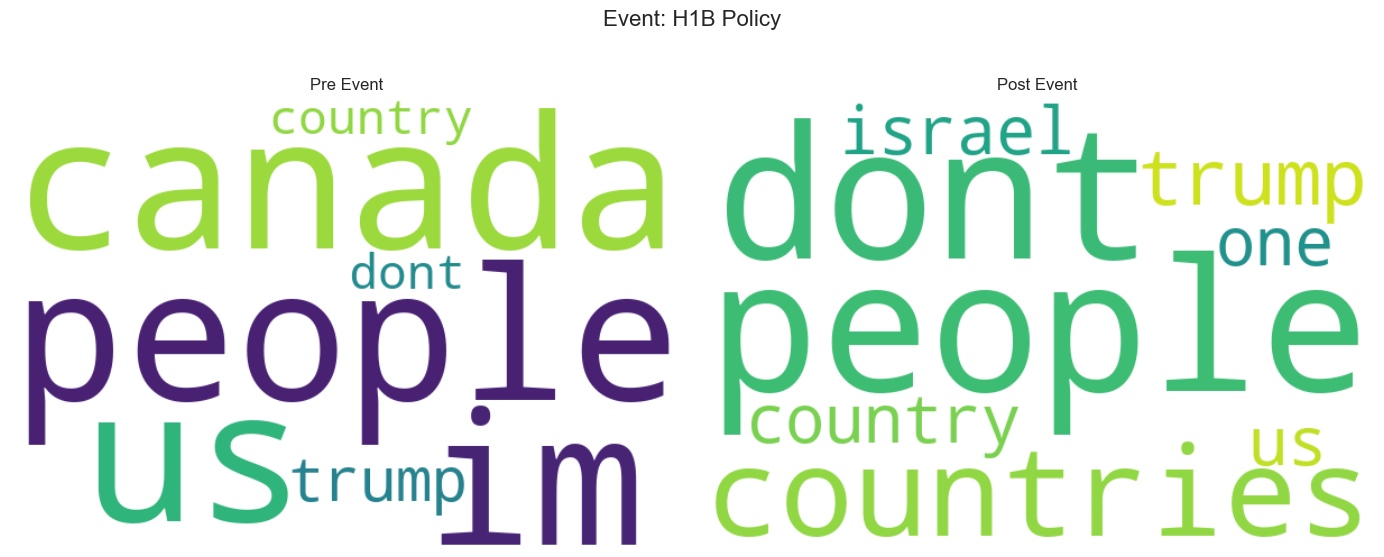

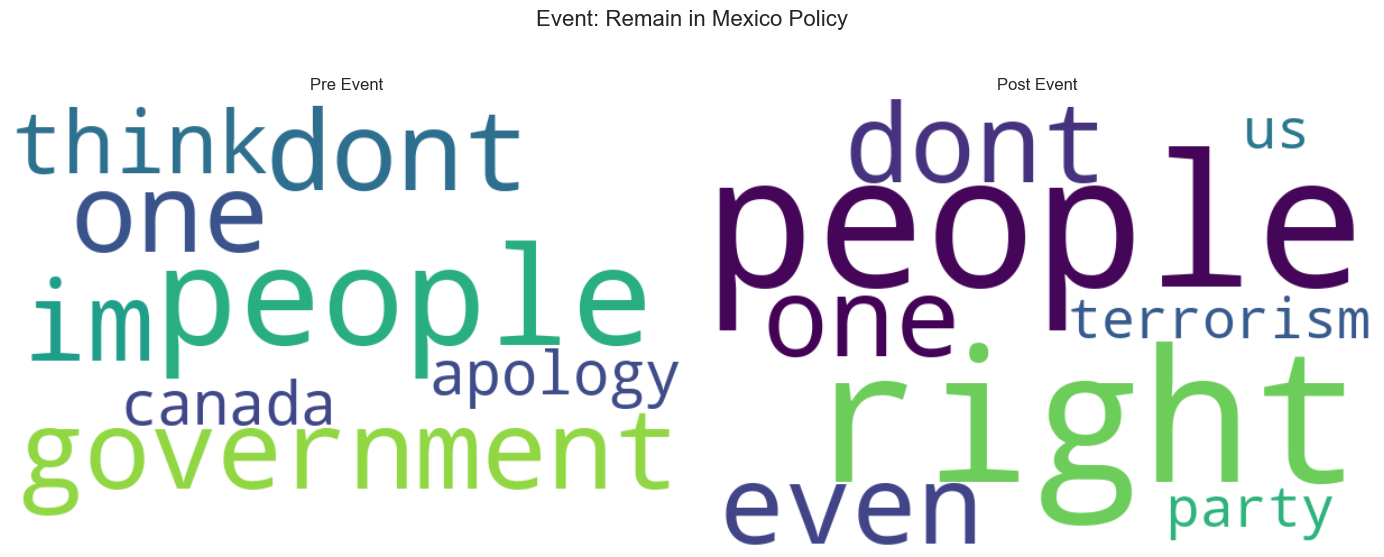

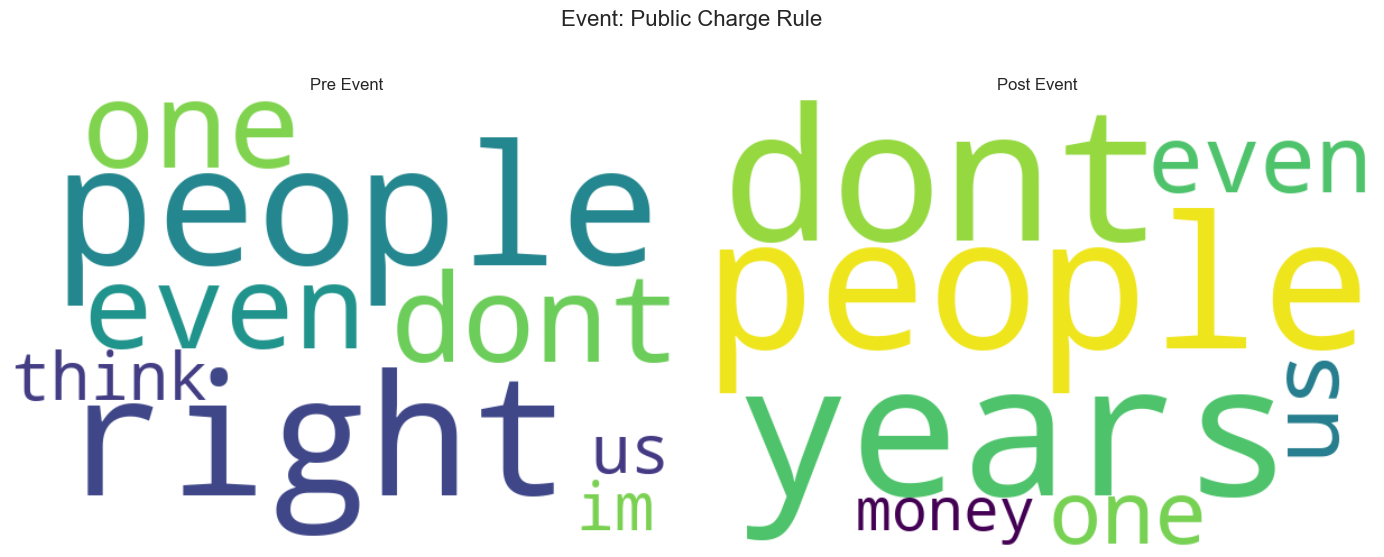

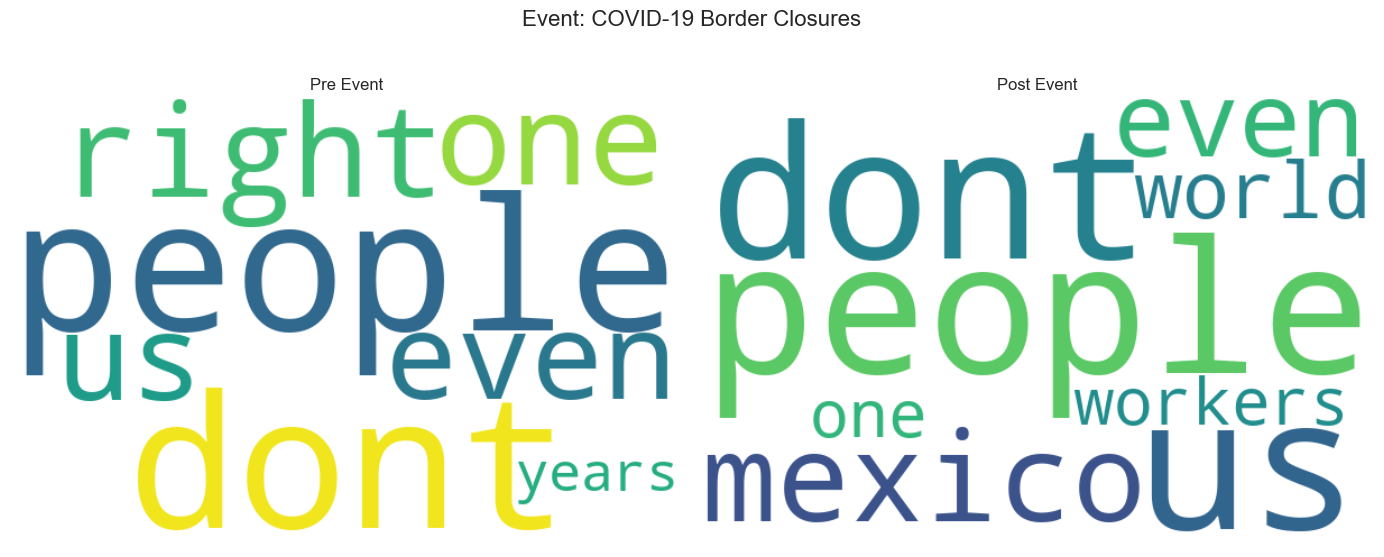

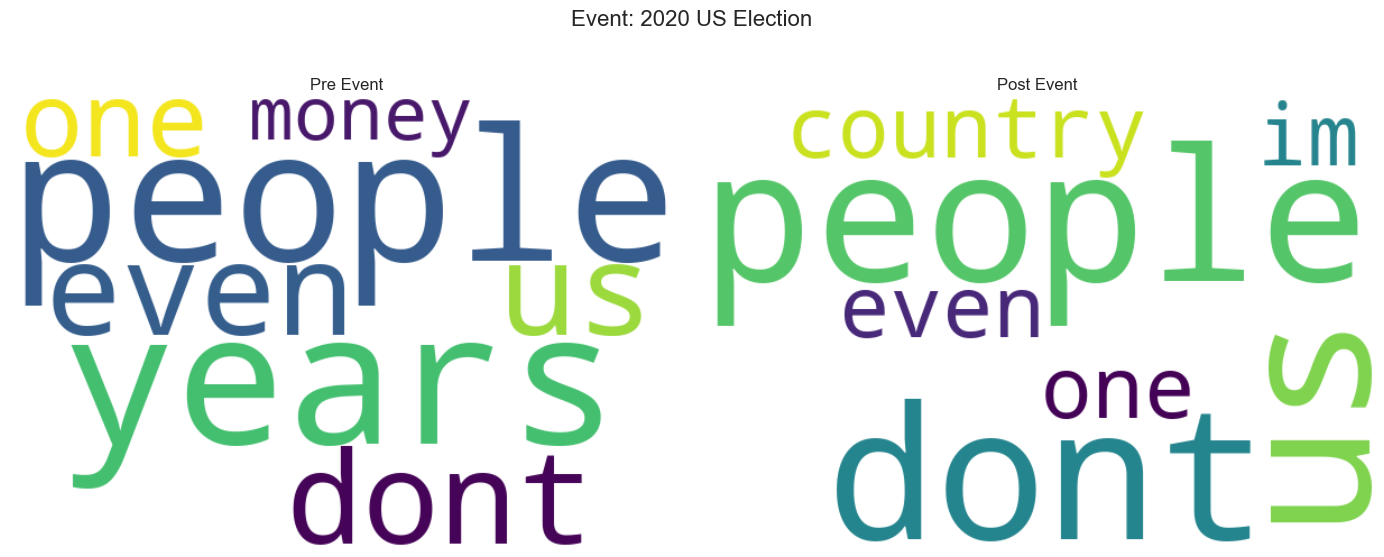

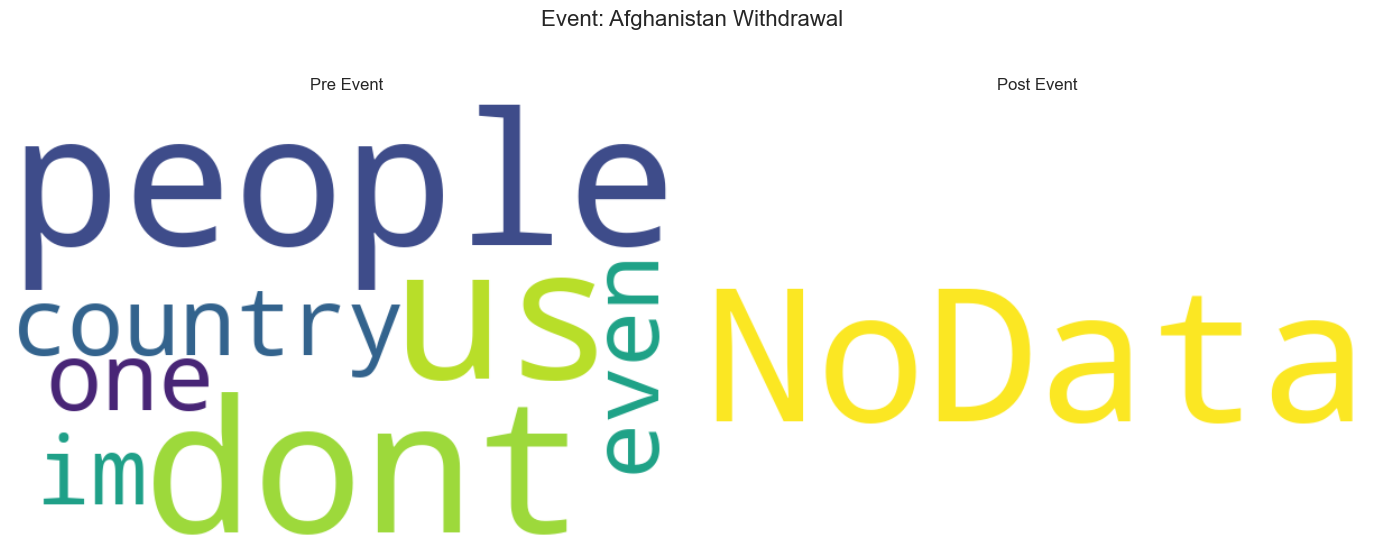

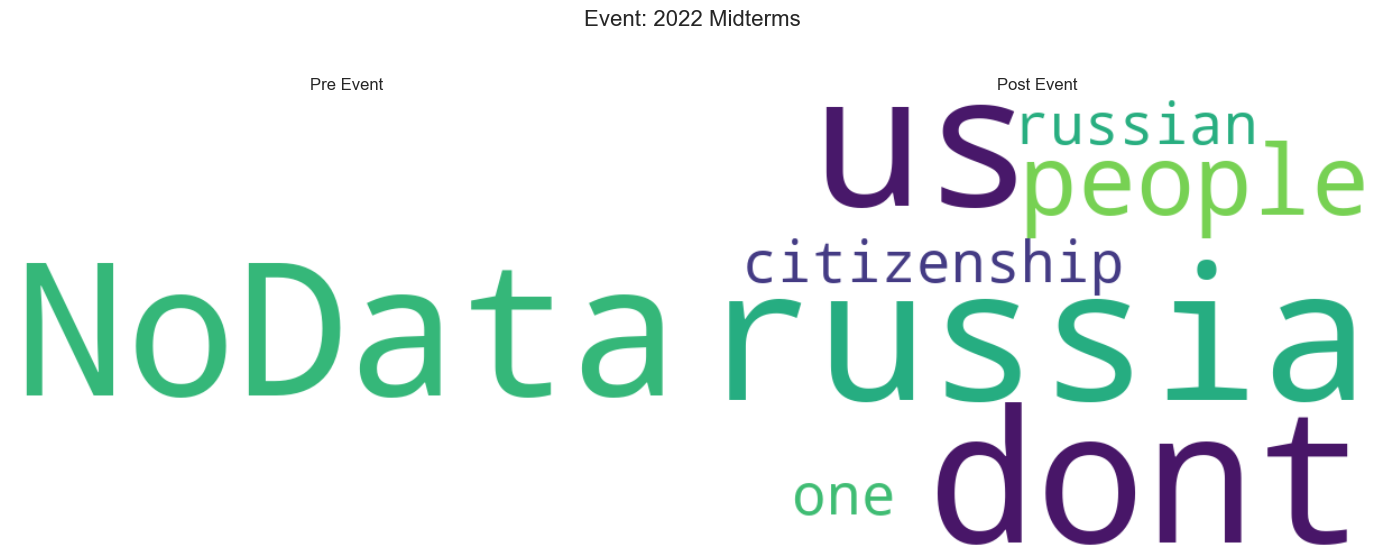

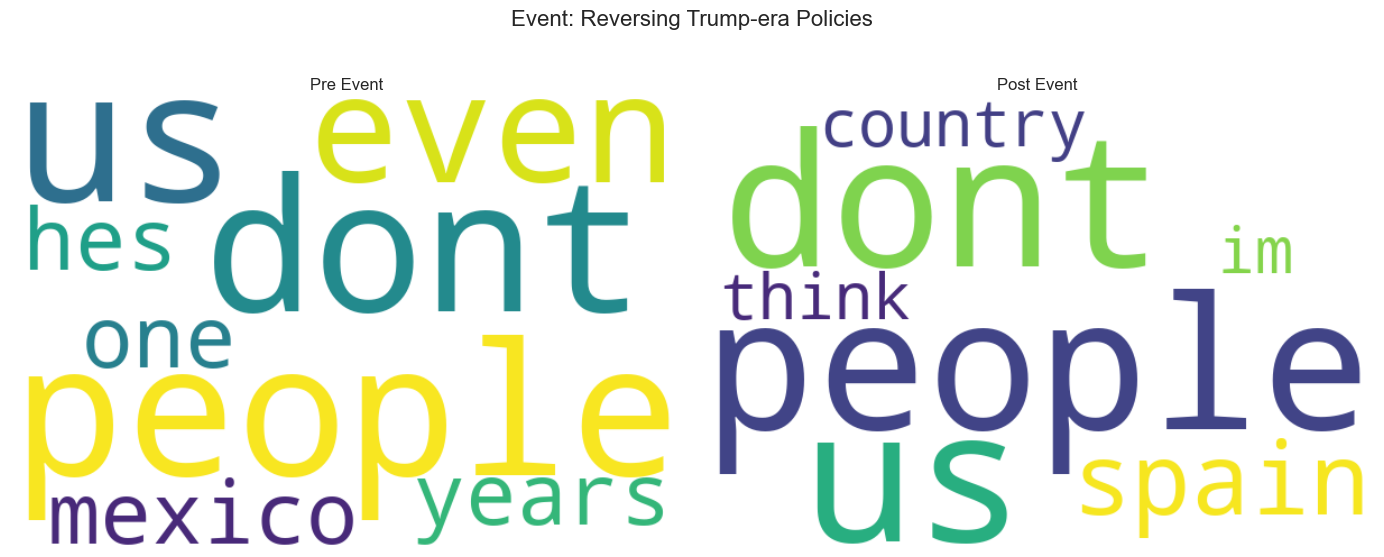

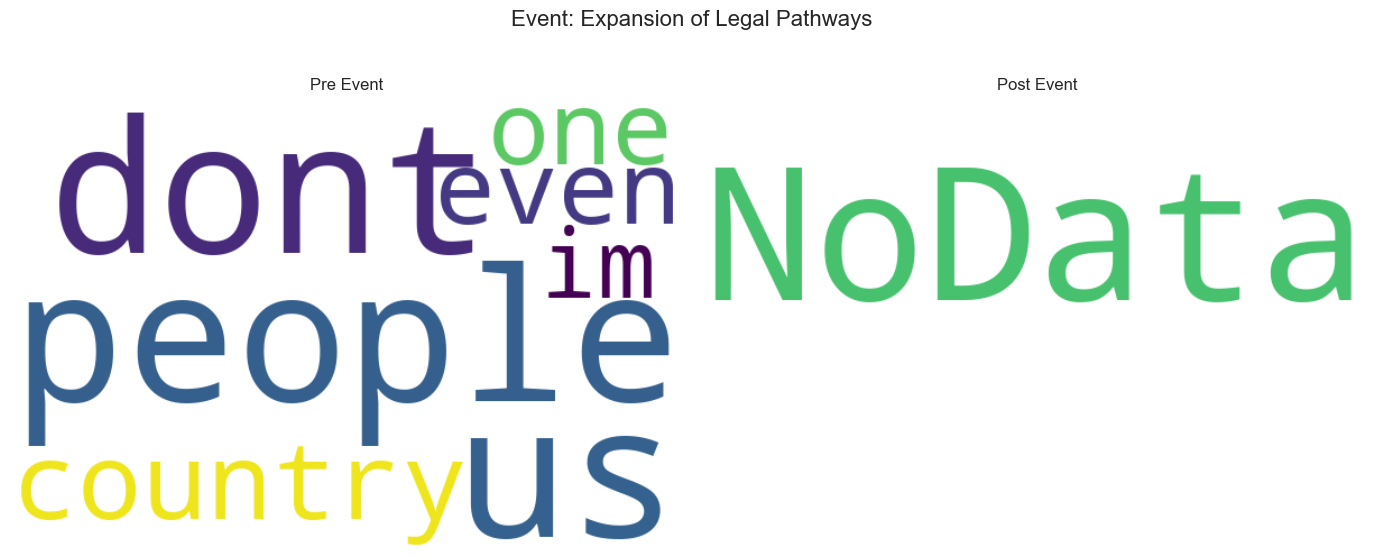

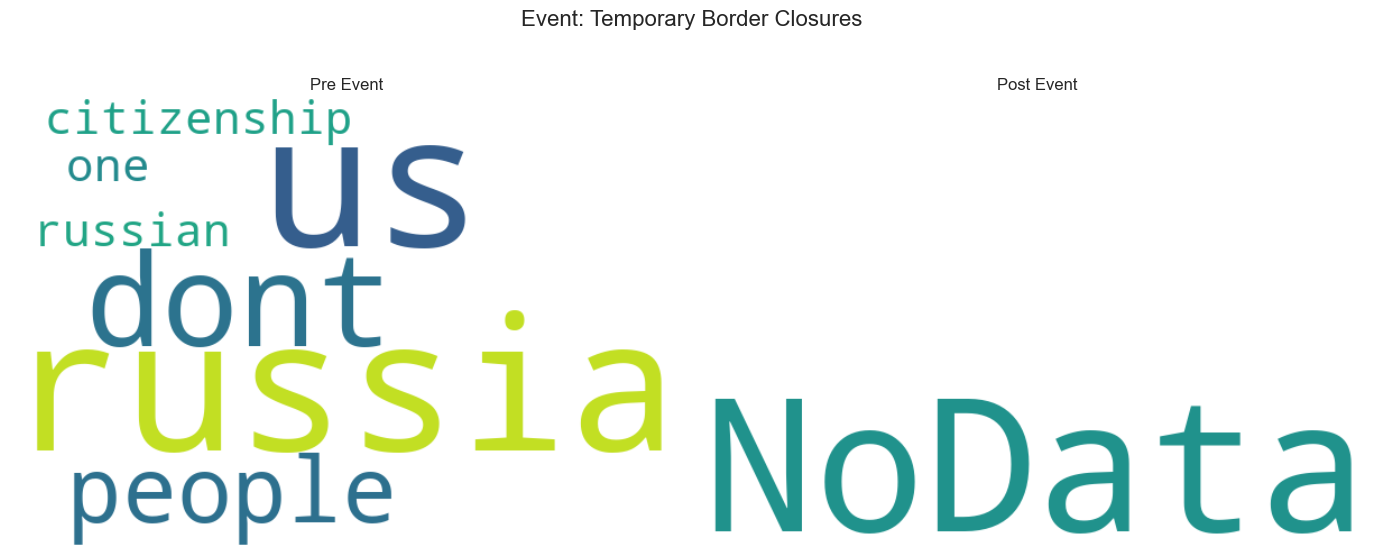

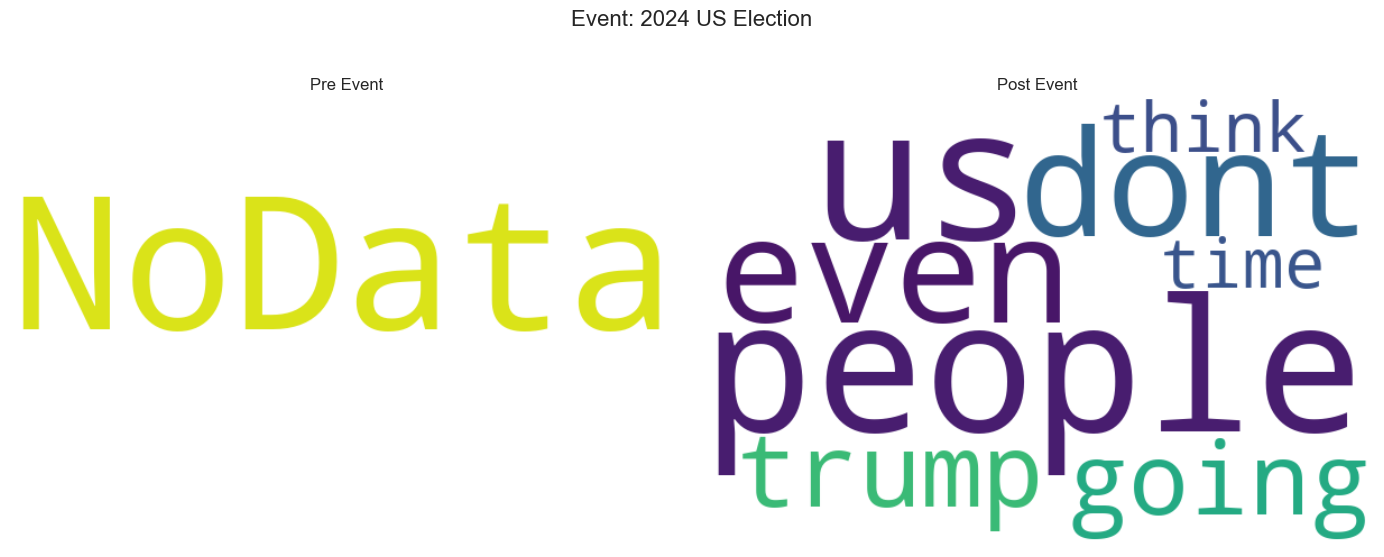

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to safely extract words
def extract_words(word_list):
    if not isinstance(word_list, list):
        return ['NoData'] * 50
    return [word for word, count in word_list if count > 0] or ['NoData'] * 50

# Loop over all events
for idx, event_row in word_freq_df.iterrows():
    event_name = event_row['Event']
    
    # Extract words safely
    pre_words_list = extract_words(event_row['Pre Top Words'])
    post_words_list = extract_words(event_row['Post Top Words'])
    
    pre_words = ' '.join(pre_words_list)
    post_words = ' '.join(post_words_list)
    
    # Plot side-by-side word clouds
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(f'Event: {event_name}', fontsize=16)

    wc_pre = WordCloud(width=600, height=400, background_color='white',
                       min_font_size=10, max_words=100).generate(pre_words)
    axes[0].imshow(wc_pre, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Pre Event')

    wc_post = WordCloud(width=600, height=400, background_color='white',
                        min_font_size=10, max_words=100).generate(post_words)
    axes[1].imshow(wc_post, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Post Event')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

